In [129]:
# imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import wbdata
import pycountry_convert as pc
from pycountry import countries
import miceforest as mf
import missingno as msno
import numpy as np

In [130]:
# run so that tourism <- original data until 2020
tourism = pd.read_csv('tourism.csv')
tourism = tourism[tourism['year'] < 2020]

In [131]:
# run so that countries <- list of valid countries && continent <- continent
# Add continent info

def country_to_continent(code):
    try:
        alpha2 = countries.get(alpha_3=code).alpha_2
        cont_code = pc.country_alpha2_to_continent_code(alpha2)
        return pc.convert_continent_code_to_continent_name(cont_code)
    except:
        return None

tourism['continent'] = tourism['country_code'].apply(country_to_continent)
tourism = tourism.dropna(subset=['continent'])

countries = tourism['country'].unique()

In [138]:
# run to add tourism_spending_ratio
tourism['tourism_spending_ratio'] = tourism['tourism_receipts']/tourism['tourism_arrivals']

In [132]:
# run so that tourism['population'] gets filled

# Define indicator
indicator = {'SP.POP.TOTL': 'population'}

# Fetch data
copy = wbdata.get_dataframe(indicator)

# Reset index
copy = copy.reset_index()
# Filter years
copy['population'] = copy.dropna()['population'].astype(int)
copy['year'] = copy['date'].astype(int)
copy = copy[copy['year'] >= 1999]
copy = copy[copy['year'] <= 2019]

# merge on year and country
tourism = tourism.merge(copy, on=['country', 'year'], how = 'inner')


In [133]:
# run so that receipts and arrivals are logged
tourism['tourism_arrivals'] = tourism['tourism_arrivals'].apply(np.log)
tourism['tourism_receipts'] = tourism['tourism_receipts'].apply(np.log)

<Axes: >

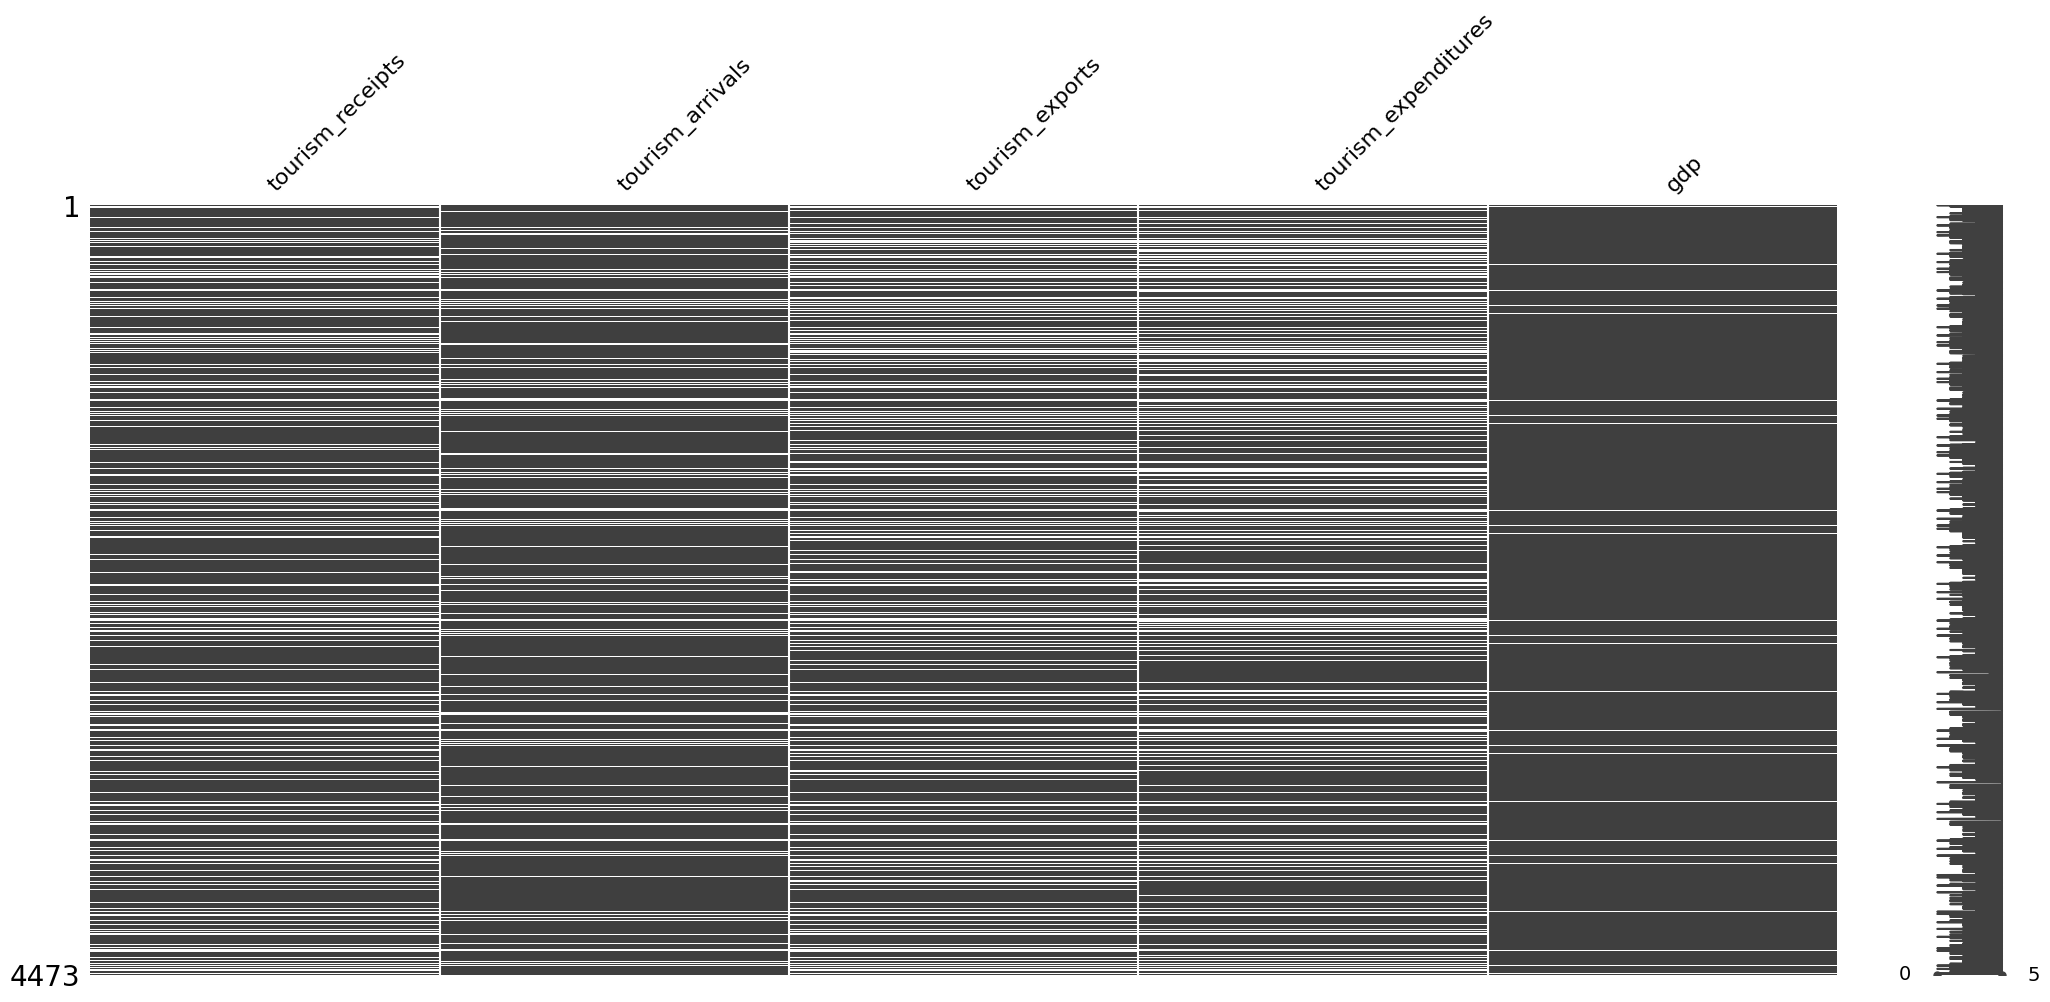

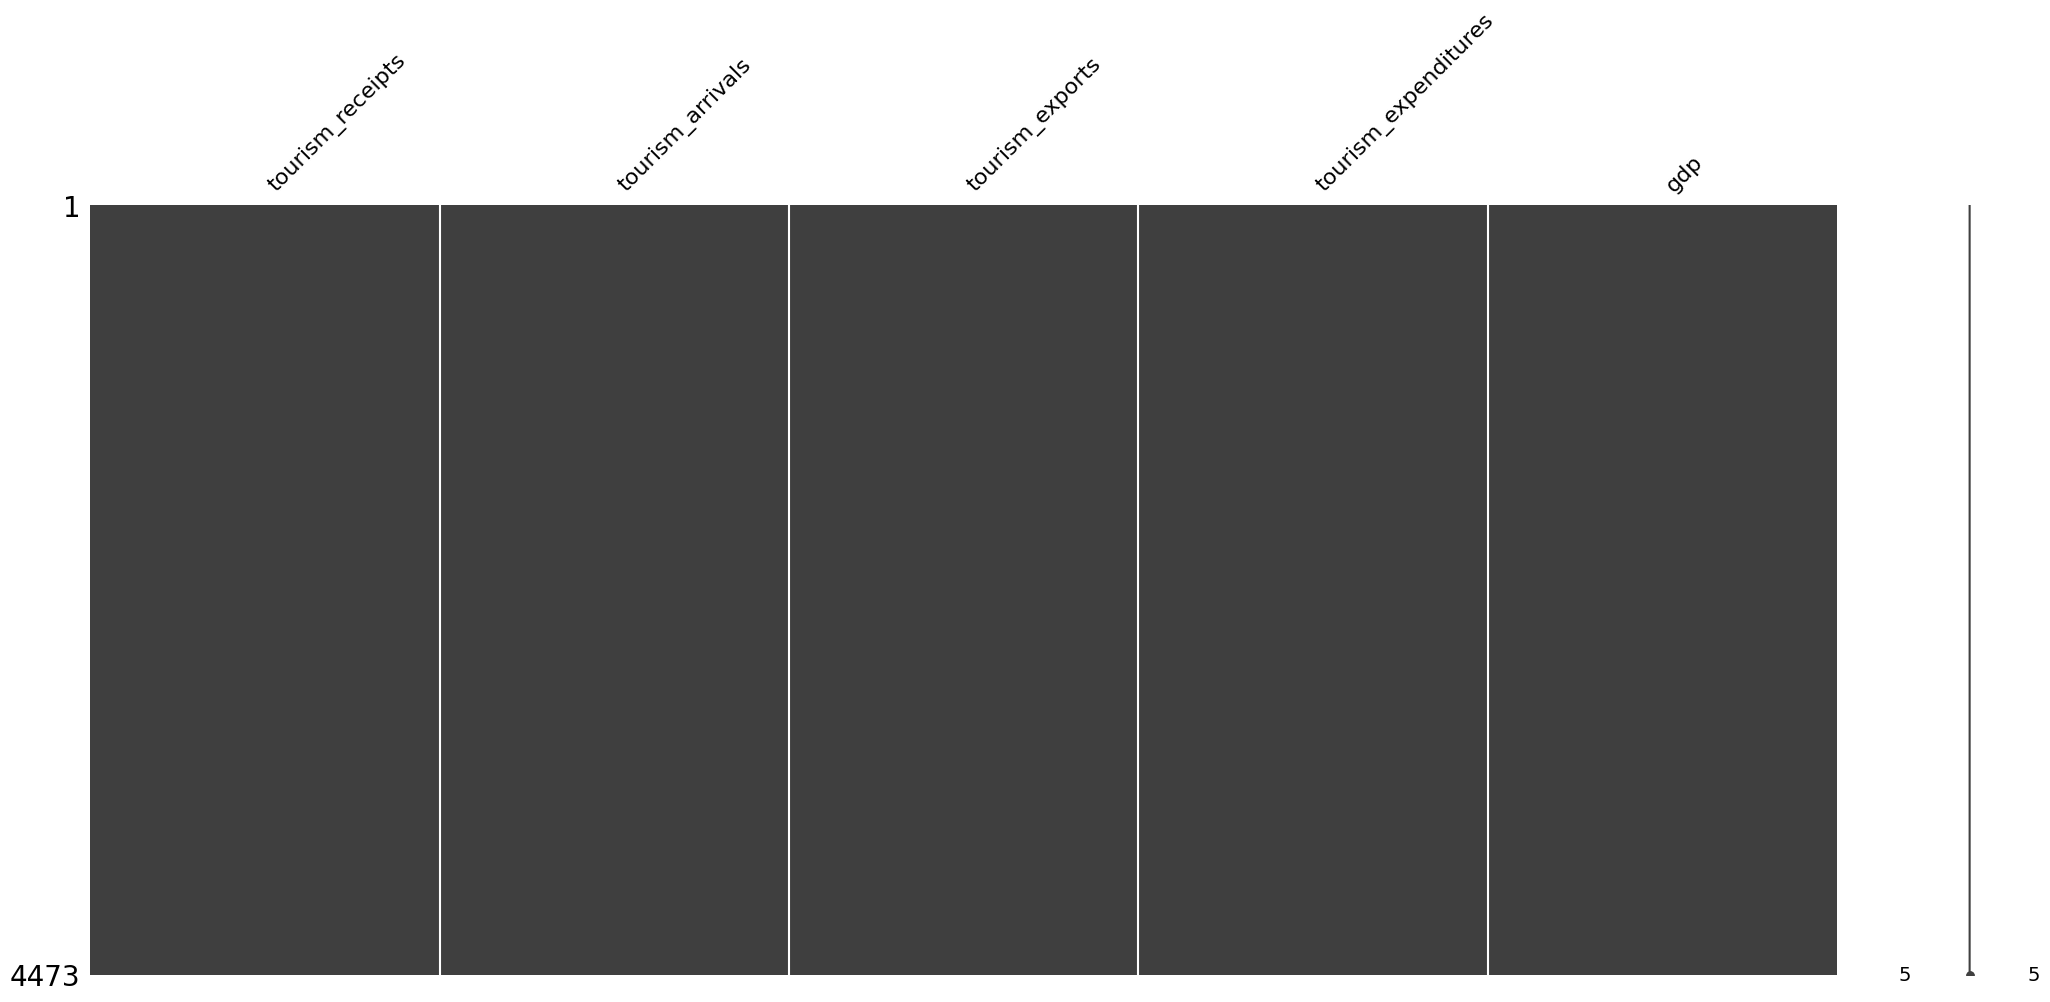

In [134]:
# Set categories
tourism['country_code'] = tourism['country_code'].astype('category')
tourism['continent'] = tourism['continent'].astype('category')

# Select relevant columns
cols = ['country_code', 'continent', 'year', 'tourism_receipts', 'tourism_arrivals', 'tourism_exports', 'tourism_expenditures','gdp', 'population']
tourism = tourism.reset_index(drop=True)


# impute
kernel = mf.ImputationKernel(
    tourism[cols],
    random_state=42
)
kernel.mice(3)

# Get imputed data
completed_df = kernel.complete_data(0)

# Visualize
imputed_cols = ['tourism_receipts', 'tourism_arrivals', 'tourism_exports', 'tourism_expenditures', 'gdp']
msno.matrix(tourism[imputed_cols])
msno.matrix(completed_df[imputed_cols])


In [ ]:
# this imputes tourism by continent
continents = ['Noth America', 'South America', 'Europe', 'Asia', 'Africa', 'Oceania']
for cont in continents:
    copy = tourism[tourism['continent'] == cont].copy()
    copy = copy.reset_index(drop=True)

    # Keep only numeric columns
    numeric_cols = copy.select_dtypes(include=['number']).columns
    copy_numeric = copy[numeric_cols]

    kernel = mf.ImputationKernel(copy, random_state=42)
    kernel.mice(3)
    completed_df = kernel.complete_data(0)
    tourism.loc[tourism['continent'] == cont, :] = completed_df.values

tourism

AssertionError: convert object dtypes to something else

In [ ]:
# test errors with different gdp groups
copy = tourism.copy()
copy = copy.reset_index()

# Step 1: Mask known values (simulate missingness)
cols = ['country_code', 'year', 'tourism_receipts', 'tourism_arrivals', 'tourism_exports', 'tourism_expenditures','tourism_spending_ratio', 'continent', 'gdp', 'population', 'inflation', 'unemployment']
imputed_cols = ['tourism_receipts', 'tourism_arrivals', 'tourism_exports', 'tourism_expenditures','tourism_spending_ratio']

masked_df = copy[cols].copy()
ground_truth = {}

for col in imputed_cols:
    known = masked_df[col].dropna()
    idx = known.sample(frac=0.2, random_state=42).index
    ground_truth[col] = copy.loc[idx, col]  # Store real values
    masked_df.loc[idx, col] = np.nan      # Mask them


for col in masked_df.columns:
    if masked_df[col].dtype == 'object':
        try:
            # Try converting to numeric
            masked_df[col] = pd.to_numeric(masked_df[col])
        except:
            # If it fails, convert to category
            masked_df[col] = masked_df[col].astype('category')


# Step 2: Run MICE
kernel = mf.ImputationKernel(masked_df, random_state=42)
kernel.mice(3)
completed_df = kernel.complete_data(0)

# Step 3: Compare imputed vs real
for col in imputed_cols:
    truth = ground_truth[col]
    imputed = completed_df.loc[truth.index, col]
    errors = imputed - truth
    
    rmse = np.sqrt((errors ** 2).mean())
    mae = errors.abs().mean()

    # Calculate relative errors by dividing errors by the true values' magnitude
    rel_rmse = np.sqrt(((errors / truth) ** 2).mean()) * 100  # % RMSE
    rel_mae = (errors.abs() / truth).mean() * 100            # % MAE

    print(f"{col}:")
    print(f"  RMSE = {rmse:.2f}")
    print(f"  Relative RMSE = {rel_rmse:.2f}%")


tourism_receipts:
  RMSE = 0.65
  Relative RMSE = 3.38%
tourism_arrivals:
  RMSE = 0.71
  Relative RMSE = 5.87%
tourism_exports:
  RMSE = 7.59
  Relative RMSE = 161.41%
tourism_expenditures:
  RMSE = 3.07
  Relative RMSE = 189.80%
tourism_spending_ratio:
  RMSE = 0.05
  Relative RMSE = 3.43%


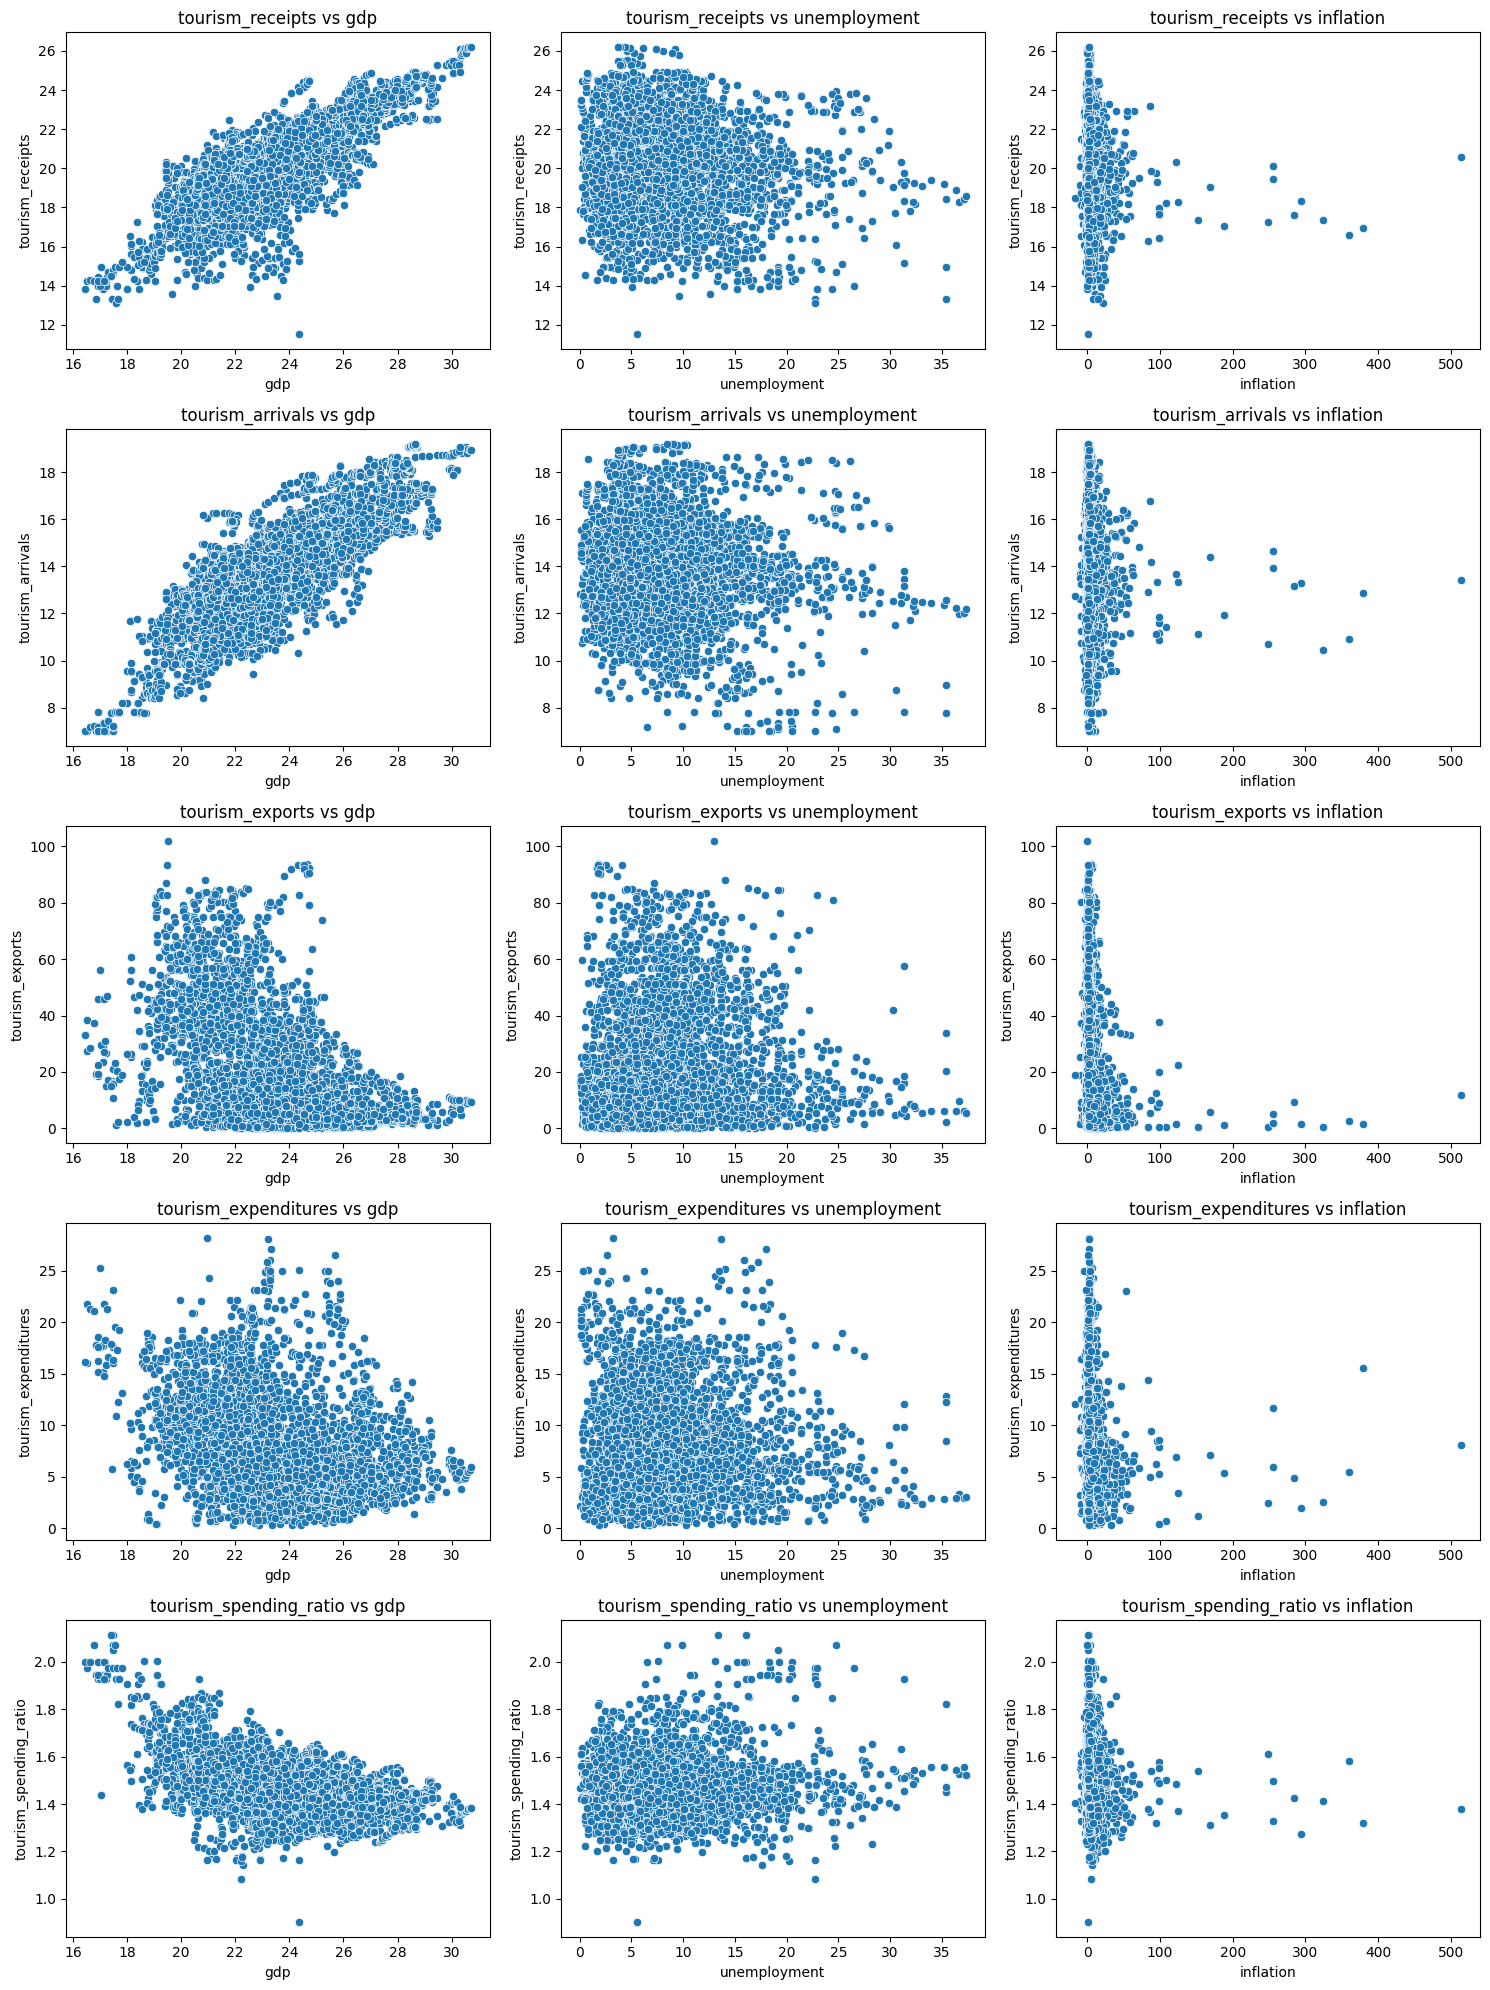

In [141]:

data = completed_df
data['gdp'] = data['gdp'].apply(np.log)
# Columns to plot
tourism_columns = ['tourism_receipts', 'tourism_arrivals', 'tourism_exports',
                   'tourism_expenditures', 'tourism_spending_ratio']
economic_columns = ['gdp', 'unemployment', 'inflation']

# Set up the plot grid
num_rows = len(tourism_columns)
num_cols = len(economic_columns)
fig, axes = plt.subplots(num_rows, num_cols, figsize=(5 * num_cols, 4 * num_rows))

# If only 1 row or 1 col, make sure axes is 2D for consistent indexing
if num_rows == 1:
    axes = [axes]
if num_cols == 1:
    axes = [[ax] for ax in axes]

# Plot each tourism column against each economic column
for i, tourism_col in enumerate(tourism_columns):
    for j, econ_col in enumerate(economic_columns):
        ax = axes[i][j]
        sns.scatterplot(data=data, x=econ_col, y=tourism_col, ax=ax)
        ax.set_title(f'{tourism_col} vs {econ_col}')
        ax.set_xlabel(econ_col)
        ax.set_ylabel(tourism_col)

plt.tight_layout()
plt.show()